In [1]:
import math
from scipy import integrate
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from cardano_method import CubicEquation

In [2]:
pi = math.pi
q = 1.602176634e-19 # elementary charge
m0 = 9.1093837015e-31 # electron mass
mRel = 0.342 # b-Ga2O3 relative reduced electron mass 
m = mRel * m0 # b-Ga2O3 reduced electron mass
h = 6.62607015e-34 # Planck constant
hBar = h/6/pi
kB = 1.380649e-23 # Boltzmann constant
e0 = 8.8541878128e-12 # vacuum permittivity
eOpt = 3.57 # optical dielectric constant of b-Ga2O3
eSta = 10 # static dielectric constant of b-Ga2O3
T = 295 # device temperature
kT = kB*T 
Nc = 1e-6*2*(2*pi*m*kT/h**2)**1.5
n = 1.6e16 # sample carrier concentration in cm-3
phiM = kT*np.log(Nc/n)/q # Ec-Ef in eV  
#phi = 1 # Barrier height in eV
A = 4*pi*q*m*kB**2/h**3 # effective Richarson constant in A/m2/K2
aOpt = q/16/pi/eOpt/e0 # coefficient a (with the negative sign, optic) in front of the 1/x term of the potential a = e/(16*pi*e)
aSta = q/16/pi/eSta/e0 # coefficient a (with the negative sign, static) in front of the 1/x term of the potential a = e/(16*pi*e)
b = q*n*1e6/2/e0/eSta # coefficient b (V/m2) in front of the quadratic term of the potential b = q*n/2e
print (kT/q)

0.025421133123328277


In [50]:
def fF (phiB, Vr): # surface electrical field in V/m
    return ((2*q*n*1e6*(phiB-Vr-phiM-kT/q)/eSta/e0)**0.5)
def fWd (phiB, Vr): # depletion width in nm
    return ((2/q/n/1e6*(phiB-Vr-phiM-kT/q)*eSta*e0)**0.5*1e9)
def fXmax(phiB, Vr, a): # position in nm, at which the top of the potential barrier reaches maximum  
    equation = CubicEquation([2*b*1e-18,-fF(phiB,Vr)*1e-9,0,a*1e9]) # coefficients are converted so that the solutions give results in nm
    return (equation.answers[2].real) # first solution is ~ Wd, second is ~ -xmax, and third is xmax
def fEmax(phiB, Vr, a): # top of the potential barrier in eV
    x = fXmax(phiB, Vr, a)*1e-9 # convert xmax back to m
    return (phiB - fF(phiB,Vr)*x - a/x + b*x**2)
def fX1X2(W, phiB, Vr, a): # returns an array with positions x1, x2 in nm, where W and E intersect 
    # W is in V, if it is energy it would be measusred in eV
    equation = CubicEquation([b*1e-18,-fF(phiB,Vr)*1e-9,phiB-W,-a*1e9])# coefficients are converted so that the solutions give results in nm
    return ([equation.answers[1].real, equation.answers[2].real])
    #return(equation.answers)
def fIntegrand(x, W, phiB, F, a, b): # returns function that needs to be integrated, unit is V^0.5
    # x is in nanometer, W, phiB in V, F in V/m, a V*m, b in V/m2
    y = x*1e-9
    return ((phiB-W-F*y-a/y+b*y**2)**0.5)
def fProb(W, phiB, Vr, a): # returns probability of the transition of electons with energy W (in eV in this case)
    x1,x2 = fX1X2(W,phiB,Vr, a)
    F = fF(phiB, Vr)
    if W >= fEmax(phiB, Vr, a):
        result = 1
    else:
        rIntegral = integrate.quad(fIntegrand, x1, x2, args = (W, phiB, F, a, b))[0]
        print(f"rIntegral: ", rIntegral, " x1: ", x1, " x2: ", x2, " W: ", W)
        try:
            result = 1/(1 + math.exp((8*m*q)**0.5/hBar*rIntegral*1e-9))
        except OverflowError:
            result = 0
    return (result)
def fDiffJ(W, phiB, Vr, a): # returns differential current density in A/cm2/eV at energy W in eV (or V)
    return (A*T/kB*fProb(W, phiB, Vr, a)*math.log(1 + math.exp(-W*q/kT))*1e-4*q)
print(fEmax(1, 0, aOpt))
print(fProb(0.948, 1, 0, aOpt))

0.9473471655048877
1


In [59]:
arrDelW = np.linspace(0.001, 0.2, 200) # array of different in eV from the top of the potential
arrProb = [(fProb(fEmax(1,0,aOpt)-delW,1,0, aOpt)) for delW in arrDelW] 

rIntegral:  0.037603551606492064  x1:  3.162538  x2:  4.678481  W:  0.9463471655048877
rIntegral:  0.07548932493085177  x1:  2.917851  x2:  5.072421  W:  0.9453471655048877
rIntegral:  0.11365602413200224  x1:  2.743881  x2:  5.39574  W:  0.9443471655048877
rIntegral:  0.15210237706811042  x1:  2.605968  x2:  5.683098  W:  0.9433471655048877
rIntegral:  0.19082713444095548  x1:  2.490766  x2:  5.947842  W:  0.9423471655048877
rIntegral:  0.22982906942249018  x1:  2.391468  x2:  6.196779  W:  0.9413471655048877
rIntegral:  0.26910697696596164  x1:  2.304054  x2:  6.433929  W:  0.9403471655048877
rIntegral:  0.3086596730592339  x1:  2.22592  x2:  6.661896  W:  0.9393471655048877
rIntegral:  0.3484859946391111  x1:  2.155268  x2:  6.88248  W:  0.9383471655048877
rIntegral:  0.38858479912360255  x1:  2.090794  x2:  7.096982  W:  0.9373471655048877
rIntegral:  0.4289549634256494  x1:  2.031522  x2:  7.30638  W:  0.9363471655048877
rIntegral:  0.46959538364489456  x1:  1.976698  x2:  7.51142

In [60]:
arrW = np.linspace(0.001, 1, 1000)
arrDiffJ = [(fDiffJ(W, 1, 0, aOpt)) for W in arrW]

rIntegral:  153.2416479854327  x1:  0.101065  x2:  239.267149  W:  0.001
rIntegral:  153.03960771876433  x1:  0.101167  x2:  239.267099  W:  0.002
rIntegral:  152.8372112680739  x1:  0.101268  x2:  239.267048  W:  0.003
rIntegral:  152.63445669436342  x1:  0.10137  x2:  239.266997  W:  0.004
rIntegral:  152.43134168991205  x1:  0.101472  x2:  239.266946  W:  0.005
rIntegral:  152.227863894921  x1:  0.101574  x2:  239.266895  W:  0.006
rIntegral:  152.0240209205979  x1:  0.101676  x2:  239.266844  W:  0.007
rIntegral:  151.8198099221551  x1:  0.101779  x2:  239.266792  W:  0.008
rIntegral:  151.61522928219242  x1:  0.101882  x2:  239.266741  W:  0.009000000000000001
rIntegral:  151.41027571687846  x1:  0.101985  x2:  239.266689  W:  0.010000000000000002
rIntegral:  151.2049475186019  x1:  0.102088  x2:  239.266638  W:  0.011
rIntegral:  150.99924132212428  x1:  0.102192  x2:  239.266586  W:  0.012
rIntegral:  150.79315500076368  x1:  0.102295  x2:  239.266534  W:  0.013000000000000001
r

rIntegral:  49.74685616082546  x1:  0.176383  x2:  106.06543  W:  0.427
rIntegral:  49.59005490031457  x1:  0.176693  x2:  105.805873  W:  0.428
rIntegral:  49.43356027704883  x1:  0.177003  x2:  105.546818  W:  0.429
rIntegral:  49.27737135389025  x1:  0.177315  x2:  105.288261  W:  0.43
rIntegral:  49.12148722234619  x1:  0.177628  x2:  105.030201  W:  0.431
rIntegral:  48.96590697419998  x1:  0.177942  x2:  104.772634  W:  0.432
rIntegral:  48.81062970906887  x1:  0.178257  x2:  104.515557  W:  0.433
rIntegral:  48.65565453431973  x1:  0.178573  x2:  104.258968  W:  0.434
rIntegral:  48.500980564520226  x1:  0.17889  x2:  104.002864  W:  0.435
rIntegral:  48.34660691498444  x1:  0.179209  x2:  103.747241  W:  0.436
rIntegral:  48.19253272184371  x1:  0.179529  x2:  103.492098  W:  0.437
rIntegral:  48.03875712768457  x1:  0.179849  x2:  103.237431  W:  0.438
rIntegral:  47.885279263500976  x1:  0.180171  x2:  102.983238  W:  0.439
rIntegral:  47.73209828626597  x1:  0.180494  x2:  1

rIntegral:  5.596906746163642  x1:  0.639954  x2:  23.974586  W:  0.838
rIntegral:  5.533304300223356  x1:  0.644161  x2:  23.80958  W:  0.839
rIntegral:  5.469916572046379  x1:  0.648425  x2:  23.644637  W:  0.84
rIntegral:  5.406743829346284  x1:  0.652747  x2:  23.479756  W:  0.841
rIntegral:  5.343786331269684  x1:  0.65713  x2:  23.314934  W:  0.842
rIntegral:  5.281044365750018  x1:  0.661573  x2:  23.150171  W:  0.843
rIntegral:  5.218518201207225  x1:  0.666079  x2:  22.985465  W:  0.844
rIntegral:  5.156208121278096  x1:  0.670649  x2:  22.820814  W:  0.845
rIntegral:  5.094114413771397  x1:  0.675284  x2:  22.656216  W:  0.846
rIntegral:  5.03223737175173  x1:  0.679985  x2:  22.49167  W:  0.847
rIntegral:  4.970577281245813  x1:  0.684755  x2:  22.327174  W:  0.848
rIntegral:  4.909134448495605  x1:  0.689594  x2:  22.162726  W:  0.849
rIntegral:  4.847909168515204  x1:  0.694505  x2:  21.998324  W:  0.85
rIntegral:  4.786901757708069  x1:  0.699488  x2:  21.833967  W:  0.85

Text(0, 0.5, 'Transmission Probability')

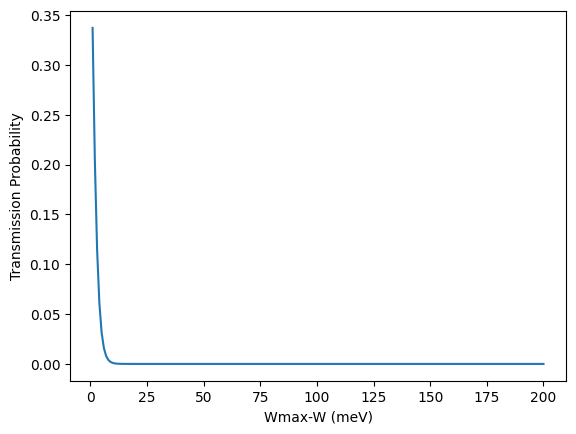

In [64]:
fig, ax = plt.subplots()
ax.plot(arrDelW*1e3, arrProb)
ax.set_yscale('linear')
plt.xlabel("Wmax-W (meV)")
plt.ylabel("Transmission Probability")

Text(0, 0.5, 'Differential Current Density (A/cm2/eV)')

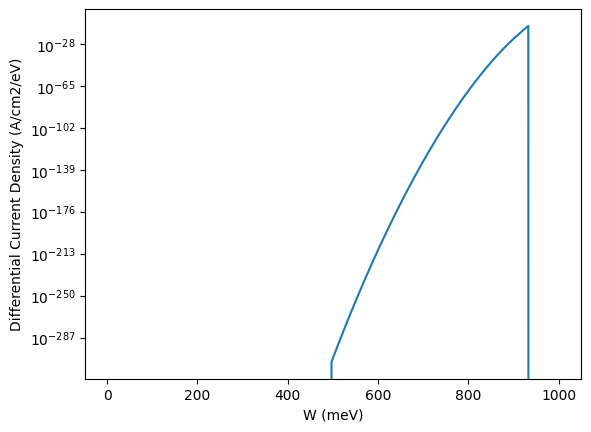

In [62]:
fig1, ax1 = plt.subplots()
ax1.plot(arrW*1e3, arrDiffJ)
ax1.set_yscale('log')
plt.xlabel("W (meV)")
plt.ylabel("Differential Current Density (A/cm2/eV)")

In [28]:
# Results if use boundaries x1, x2 in meter. Do NOT remove or delete this cell 
print(fProb(0.5,1,0, aOpt))

(1.4678359700848055e-09, 1.8292215760113234e-10)


In [122]:
print(fX1X2(0.74, 1, -250, aOpt))

[(8323.012351-0j), (0.50696-0j), (1.650888+0j)]


In [40]:
print (fIntegrand(1e-9,0.5, 1, fF(1,-500),aOpt, b))

nan


/tmp/ipykernel_1187/1361195881.py:18: RuntimeWarning: invalid value encountered in scalar power
  return ((phiB-W-F*y-a/y+b*y**2)**0.5)


In [28]:
# Do NOT remove, change or delete this cell
# Results if use boundaries x1, x2 in meter. 
# Return values in V^0.5*m 
print(fProb(0.5,1,-250, aOpt))

(1.4678359700848055e-09, 1.8292215760113234e-10)


In [31]:
# Do NOT remove, change or delete this cell
# Results if use boundaries x1, x2 in meter. 
# Return values in V^0.5*nm
print(fProb(0.5,1,-250, aOpt))

(1.4677740848306249, 9.521495369924082e-09)


In [148]:
print (math.log(math.exp(1)), " ", math.exp(1))

1.0   2.718281828459045
